In [1]:
# import and load libraries
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


In [2]:
# paths
train_path = 'Bur_check/train/color'
valid_path = 'Bur_check/validation/color'
test_path = 'Bur_check/test/color'

# Load
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=21)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=13)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=10)

Found 431 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [3]:
# Showing the labels
label_map = (train_batches.class_indices)
label_map

{'damaged': 0, 'good': 1}

In [4]:
# routine to plot bur images for conference (code taken from internet)
def plots(ims, figsize=(27,27), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.array:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(valid_batches)

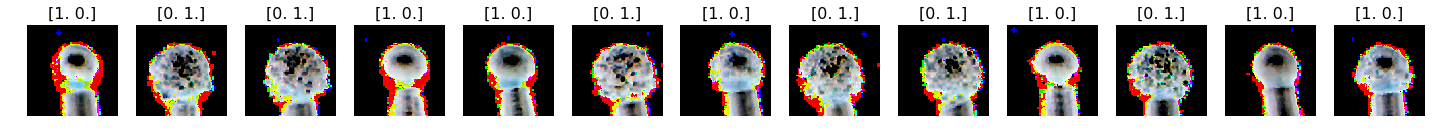

In [6]:
plots(imgs, titles=labels)

## Build and Train CNN

In [7]:
# Chosen model after hundreds of simulations :) 
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(90,90,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 90, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        51264     
__________

In [8]:
# RMSProp optimizer with lower learning rate
model.compile(RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# implementation of Early Stopping to avoid overfitting and better control of training
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 6
batch_size = 10
n_epochs = 30
model_Bur = 'Model_Bur_5'
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(model_Bur+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit_generator(train_batches, steps_per_epoch=len(train_batches) / batch_size, validation_data=valid_batches,
            validation_steps=4, epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/30
2/2 [==============================] - 13s 7s/step - loss: 6.9981 - acc: 0.5000 - val_loss: 7.4850 - val_acc: 0.5294

Epoch 00001: val_loss improved from inf to 7.48499, saving model to Model_Bur_5.h5
Epoch 2/30
2/2 [==============================] - 12s 6s/step - loss: 6.2036 - acc: 0.5714 - val_loss: 0.2616 - val_acc: 0.9412

Epoch 00002: val_loss improved from 7.48499 to 0.26156, saving model to Model_Bur_5.h5
Epoch 3/30
2/2 [==============================] - 13s 6s/step - loss: 5.7951 - acc: 0.5714 - val_loss: 0.8641 - val_acc: 0.7843

Epoch 00003: val_loss did not improve
Epoch 4/30
2/2 [==============================] - 12s 6s/step - loss: 4.0887 - acc: 0.6429 - val_loss: 0.4701 - val_acc: 0.9020

Epoch 00004: val_loss did not improve
Epoch 5/30
2/2 [==============================] - 12s 6s/step - loss: 3.4317 - acc: 0.6905 - val_loss: 1.3043 - val_acc: 0.8235

Epoch 00005: val_loss did not improve
Epoch 6/30
2/2 [==============================] - 13s 6s/step - loss: 4

['acc', 'loss', 'val_acc', 'val_loss']


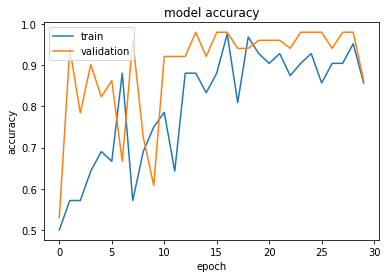

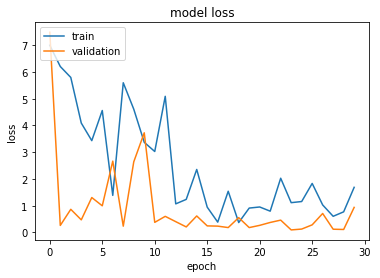

In [10]:
# Plot Acuracy and Loss (code taken from internet)
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predict

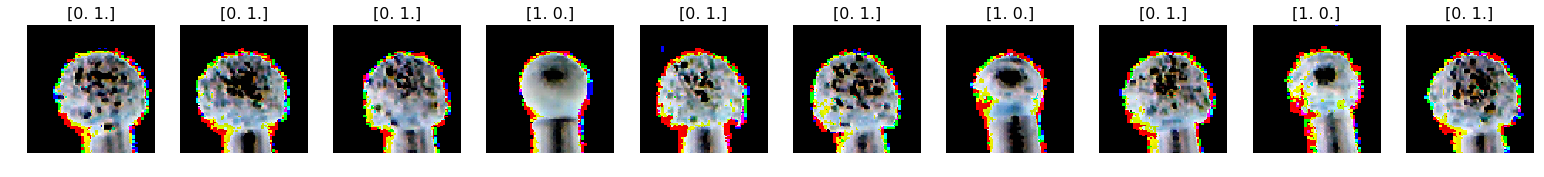

In [57]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [58]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0.], dtype=float32)

In [59]:
# predictions using also "generator" since we are working in batches
predictions = model.predict(test_imgs, steps=1, verbose=0)

In [60]:
predictions = predictions.round()

In [61]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [53]:
# accuracy under new images never seen by the algoritm
score = model.evaluate_generator(test_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.9523809552192688)


In [62]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [63]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color='white' if cm[i ,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

Confusion matrix, without normalization
[[7 0]
 [0 3]]


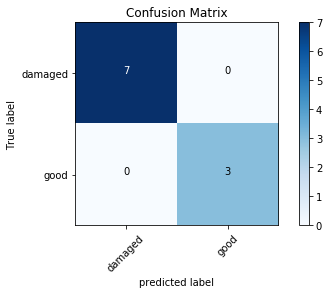

In [64]:
cm_plot_labels = ['damaged', 'good']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')

In [20]:
score = model.evaluate_generator(train_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.9791183312641772)


In [21]:
score = model.evaluate_generator(valid_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.8431372572393978)


In [27]:
# Save the models
# serialize model to JSON
model_json = model.to_json()
with open("Bur_model_app_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Bur_model_app_5.h5")
print("Saved model to disk")

Saved model to disk
